In [1]:
from torchdiffeq import odeint
import numpy as np
from matplotlib import pyplot as plt
from numpy import linalg as la
from scipy import stats
from scipy import spatial as sp
from scipy import integrate as int
import pandas as pd
import torch
import torch.nn as nn
from tqdm import tqdm


#import Networkx as net
import Plot3D as plot3d
import dataframe as dataframe

#### Neural ODE

In [2]:
class Simple_FeedforwardNN(nn.Module):
    def __init__(self, input_dim, hidden_layers, depth, output_dim, activation_func=nn.Tanh()):
        super(Simple_FeedforwardNN, self).__init__()

        layers = []
        previous_depth = input_dim
        for _ in range(hidden_layers):
            layers.append(nn.Linear(previous_depth, depth))
            layers.append(activation_func)
            previous_depth = depth

        layers.append(nn.Linear(depth, output_dim))
        self.network = nn.Sequential(*layers)

        #Setting initial weights
        for m in self.network.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.2)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, x):
            out = self.network(x)
            return out


In [118]:
class Piecewise_Auto_NODE(Simple_FeedforwardNN):
    def __init__(self, input_dim, hidden_layers, depth, output_dim, domain, num_breakpoints, activation_func=nn.Tanh()):
        super().__init__(input_dim, hidden_layers, depth, output_dim*(num_breakpoints+1), activation_func)

        self.depth              = depth #Depth is number of neurons per hidden layer
        self.hiddenlayers       = hidden_layers #Number of internal hidden layers
        self.variables          = input_dim
        self.num_breakpoint     = num_breakpoints
        self.domain             = domain
        self.num_A              = (num_breakpoints+1)*output_dim
        self.breakpoints        = torch.linspace(domain[0], domain[1], num_breakpoints+2) 
        self.break_params       = nn.Parameter(self.breakpoints[1:-1])
    

    def sigmoid_rescaled(self, x):
        a = 1 + torch.exp(-50*x)
        c = 1/a
        return c

    def forward(self, t, x):
        out = self.network(x)

        #Getting indicator function
        #index = torch.where(self.break_params < t)[0].shape[0]
        indicator = torch.concatenate([ torch.sigmoid(self.break_params - t)*((t < self.break_params).float()), torch.sigmoid(t - self.break_params)*((t > self.break_params).float())])
        #print(indicator); print('Break Param:', self.break_params)
        out2 = out*indicator
        
        

        #out[0] = out[0]*(t < self.break_params).float()
        #out[1] = out[1]*(t >= self.break_params).float()
        final_out = torch.sum(out2, dim=0)

        return final_out
    
  

#### Model

In [47]:
class SaddleNodeStable:
    def __init__(self, a, b, r):
        #Setting system parameters
        self.a = a
        self.r = r
        self.b = b

    #Differential Equation
    def f(self, t, x):
        xdot = -(x-self.a)*((x-self.b)**2 + self.r(t) )

        return np.array(xdot)

In [ ]:
def parameter_f(t):
        if t <= 7.0: 
                return -0.5
        elif t > 7.0:
                return 1
   

In [144]:
saddlenode = SaddleNodeStable(a = 0.1, b = 1, r = parameter_f)

##### Solve IVP

In [145]:
tstart = 0; tfinal =10; dt = 0.01; t_eval = np.arange(tstart, tfinal, dt)

In [146]:
output = int.solve_ivp(saddlenode.f, t_span=(tstart, tfinal), y0=[1.0],
                        method = 'RK45', t_eval = t_eval)
data1 = output.y


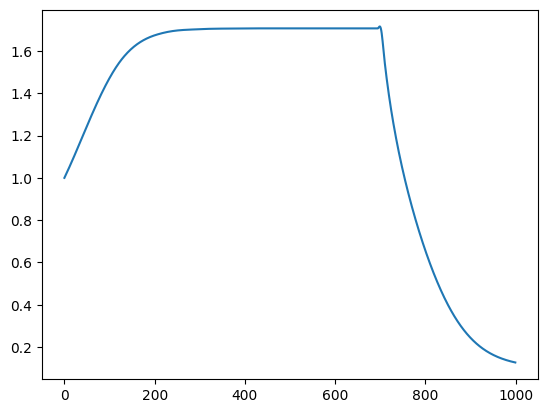

In [147]:
plt.plot(data1[0, :])

#### Training 

In [148]:
#Batching function
def batch(data, t, batch_length, batch_size):
    data_length = data.shape[0]
    indices = np.random.randint(0, data_length - batch_length, batch_size)
    batch_list = []
    batch_time_list = []

    for i in range(0, batch_size):
        batch_list.append(data[indices[i]:indices[i]+batch_length, :].float())
        batch_time_list.append(t[indices[i]:indices[i]+batch_length].float().requires_grad_(True))

    return batch_list, batch_time_list
        
data1_tensor = torch.tensor(data1)
t_eval_tensor = torch.tensor(t_eval)

##### Model Parameters

In [149]:
model = Piecewise_Auto_NODE(input_dim=1, hidden_layers=2, depth = 15, output_dim=1, domain = [0, 10], num_breakpoints=1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

In [150]:
print(model)

Piecewise_Auto_NODE(
  (network): Sequential(
    (0): Linear(in_features=1, out_features=15, bias=True)
    (1): Tanh()
    (2): Linear(in_features=15, out_features=15, bias=True)
    (3): Tanh()
    (4): Linear(in_features=15, out_features=2, bias=True)
  )
)


In [153]:
loss_list = []
batch_length = 80; batch_size = 5
init = 1

In [154]:
pred_x = odeint(func = model, y0 = torch.tensor([2.0]), t = torch.arange(0, 10, 0.01), method='rk4', options={'step_size': 0.01})

In [125]:
torch.autograd.set_detect_anomaly(False)

##### Training Loop

In [155]:
a = model(t=torch.tensor([2.0]), x=torch.tensor([3.0]))


In [127]:
data1_tensor.dtype

torch.float64

In [156]:
optimizer.zero_grad()
pred_x = odeint(model, torch.tensor([1.0]).float(), t_eval_tensor.float(), method='rk4', options={'step_size': 0.01})
train_loss = loss_fn(pred_x, data1_tensor.T.float())

In [157]:
train_loss.backward()
optimizer.step()

In [158]:
print('Total Loss: ', train_loss)
print('')
print('Breakpoint: ', model.break_params)
print('')
print('Gradient of Breakpoint: ', model.break_params.grad)

Total Loss:  tensor(0.7358, grad_fn=<MseLossBackward0>)

Breakpoint:  Parameter containing:
tensor([4.9900], requires_grad=True)

Gradient of Breakpoint:  tensor([0.0190])


In [131]:
model

Piecewise_Auto_NODE(
  (network): Sequential(
    (0): Linear(in_features=1, out_features=15, bias=True)
    (1): Tanh()
    (2): Linear(in_features=15, out_features=15, bias=True)
    (3): Tanh()
    (4): Linear(in_features=15, out_features=2, bias=True)
  )
)

In [196]:
num_epochs = 100
for epoch in tqdm(range(num_epochs)):
    batch_list, batch_time_list = batch(data1_tensor.T, t_eval_tensor, batch_length=batch_length, batch_size=batch_size)
    for i in range(0, batch_size):
        batch_i = batch_list[i]
        batch_time_i = batch_time_list[i]

        optimizer.zero_grad()

        #Predicting the trajectory
        pred_x = odeint(model, batch_i[0], batch_time_i, method='rk4', options={'step_size': 0.01})

        #Calculating loss
        loss = loss_fn(pred_x, torch.tensor(batch_i))
        #loss_list.append(loss.item())

        #Backpropagation
        loss.backward()
        optimizer.step()
     
    
    if epoch%20==0:
            #Calculate training loss
            with torch.no_grad():
                pred_x = odeint(model, torch.tensor([1.0]), t_eval_tensor, method='rk4', options={'step_size': 0.01})
                train_loss = loss_fn(pred_x, data1_tensor.T)
                loss_list.append(train_loss.item())

    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {train_loss.item()}')

  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\jackr\AppData\Local\Temp\ipykernel_20376\531892986.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = loss_fn(pred_x, torch.tensor(batch_i))
  1%|          | 1/100 [00:02<04:56,  2.99s/it]

Epoch 0, Loss: 0.0007912022657996559


100%|██████████| 100/100 [03:09<00:00,  1.90s/it]


##### Analysis

In [198]:
pred_x = odeint(model, torch.tensor([1.0]), t_eval_tensor, method='rk4', options={'step_size': 0.01})

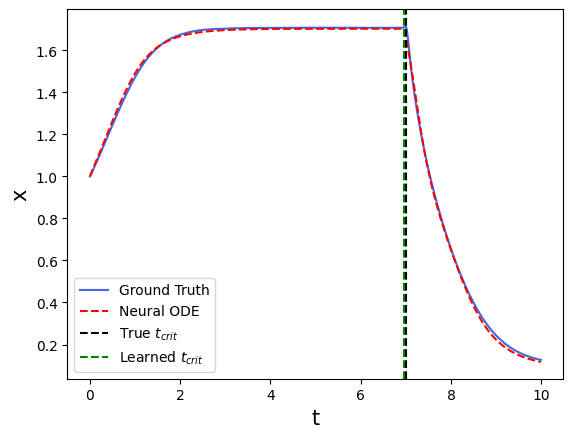

: 

In [ ]:
plt.plot(t_eval, data1[0, :], color='royalblue', label = 'Ground Truth')
plt.plot(t_eval,  pred_x.detach().numpy(), color='r', linestyle='--', label='Neural ODE')
plt.xlabel('t', fontsize=15)
plt.ylabel('x', fontsize=15)
plt.axvline(x = 7, color='k', linestyle='--', label='True '+r'$t_{crit}$')
plt.axvline(x = model.break_params.detach().numpy(), color='green', linestyle='--', label='Learned '+r'$t_{crit}$')
plt.legend()

In [191]:
model.break_params


Parameter containing:
tensor([6.9829], requires_grad=True)

In [163]:
output = int.solve_ivp(saddlenode.f, t_span=(tstart, tfinal), y0=[1.0],
                        method = 'RK45', t_eval = t_eval)
data1 = output.y

In [164]:
def sigmoid_rescaled(x):
    a = 1 + torch.exp(-50*x)
    c = 1/a
    return c

In [165]:
x= torch.tensor([-0.5])
print(torch.sigmoid(x))
print(sigmoid_rescaled(x))

tensor([0.3775])
tensor([1.3888e-11])


In [166]:
time = torch.arange(-1, 1, 0.01)

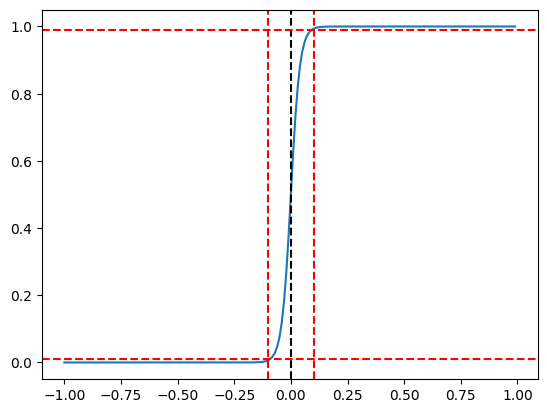

In [126]:
#plt.plot(time, torch.sigmoid(time))
plt.plot(time, sigmoid_rescaled(time))
plt.axvline(x=0, color='k', linestyle='--')
plt.axhline(y=0.01, color='r', linestyle='--')
plt.axhline(y=0.99, color='r', linestyle='--')

plt.axvline(x=-0.1, color='r', linestyle='--')
plt.axvline(x=0.1, color='r', linestyle='--')